# Введение в глубокое обучение

## Занятие 11. Компьютерное зрение. Autoencoders & GANs.

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

План занятия:

1. Автоэнкодеры:
    - Устройство автоэнкодера;
    - Генерация изображений с помощью автоэнкодера;
    - Conditional AE;
2. GAN:
    - Устройство GAN;
    - Практика: построение и обучение GAN;


В домашнем задании вам предстоить обучать автоэнкодер

## Autoencoders

### Vanilla AE

Автоэнкодер ("автокодировщик") — это нейросеть, которая учится восстанавливать информацию, поданную на вход. Другими словами, она старается на выходе выдать ровно то же, что ей подали на вход:

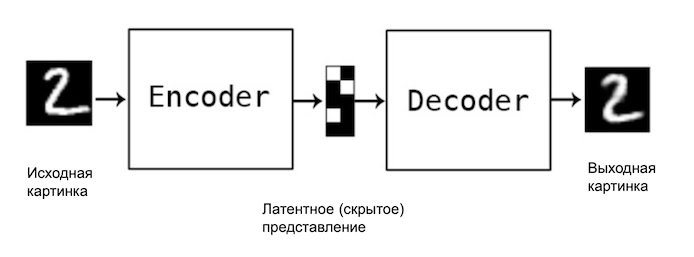

Обычно автоэнкодеры делают сужающимися к середине, т.е. количество нейронов в средних слоях сильно меньше, чем количество нейронов в первых слоях сети. И получается знакомая нам форма encoder-decoder.

Если бы в средних слоях автоэнкодера было столько же нейронов, сколько во входных слоях, то без дополнительных ограничений автоэнкодер не имел бы смысла. Он выучивал бы функцию id (identity).

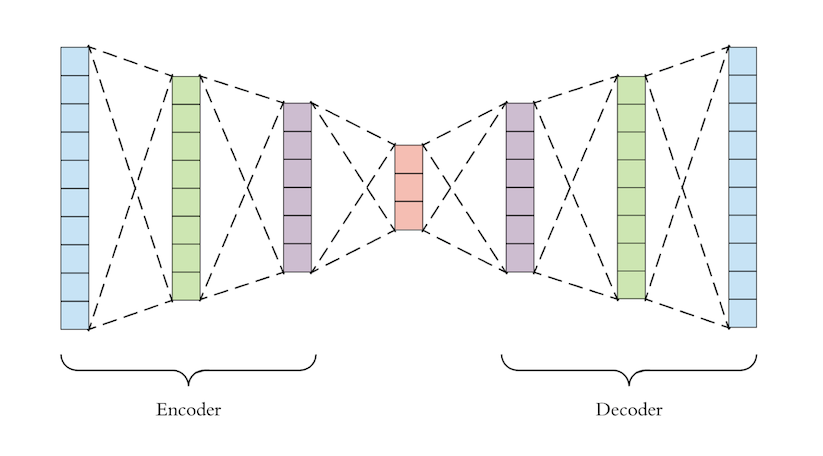

Для чего можно использовать автоэнкодеры:
- Сжатие и хранение информации. В частности, сжатие изображений/видео;
- Кластеризация объектов на основе их латентных представлений;
- Поиск похожих объектов (например, изображений);
- Генерация новых объектов (например, изображений).
- Поиск аномалий в данных;
- ... (возможно, я забыла упомянуть некоторые другие применения).


**Автоэнкодер (AE) обучается в режиме self-supervised learning**. Это значит, что для его обучения не нужно иметь разметку данных.

Например, если мы хотим обучить AE на датасете изображений лиц людей, то на каждой итерации обучения мы делаем следующее:
- подаем на вход AE картинку;
- получаем на выходе AE восстановленную картинку;
- считаем метрику качества MSE/BCE между восстановленной картинкой и той, что была подана на вход;
- обучаем AE с помощью backpropagation.

Никакой разметки данных, как в задачах классификации/детекции/сегментации не нужно.

### Генерация новых объектов с помощью AE. Вариационный AE (VAE)

Давайте подробнее обсудим, как с помощью автоэнкодеров можно генерировать новые объекты. Для простоты давайте будем считать, что мы работаем с картинками лиц людей (но все то же самое будет верно и для любых других типов объектов).

Генерация новых картинок с помощью AE:
1. Обучаем AE на нашем датасете лиц людей;
2. Выкидываем encoder часть, остается только decoder;
3. Подаем на вход decoder части случайный вектор чисел нужного размера и на выходе получаем новую картинку лица человека, которую мы не видели ранее.

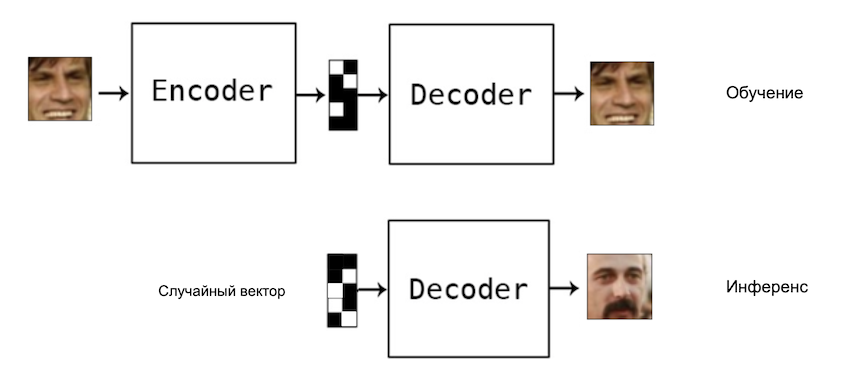

Однако с обычным ("ванильным") AE так работать не будет. Дело в том, что его латентное пространство получается довольно разреженным: не каждая точка этого пространства соответствует реальной картинке.

Латентное пространство будет выглядеть как-то так:

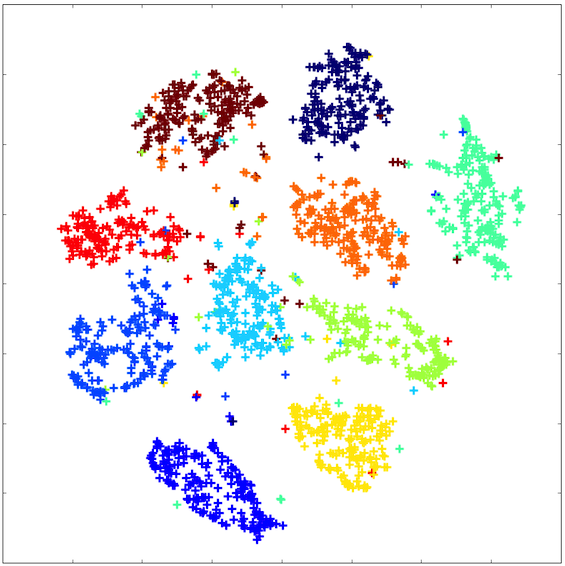

Чтобы получить AE, из векторов латентного пространства которого действительно можно генерировать новые объекты, нужно заставить AE выучивать более связное и компактное латентное пространство.

Один из способов это сделать — задать, какому распределению должны соответствовать векторы латентного пространства. Т.е. добавить ограничение на то, как далеко друг от друга могут располагаться векторы в латентном пространстве.

Такой автоэнкодер называется VAE — вариационный автоэнкодер (variational autoencoder). Его латентное пространство выглядит примерно так:

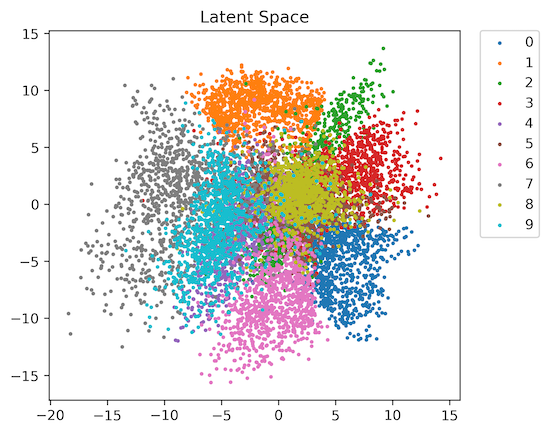

Больше информации о вариационных автоэнкодерах вы найдете в разделе "дополнительно"

### Conditional AE

Мы поняли, что с помощью VAE можно генерировать новые объекты. Давайте обсудим, как можно генерировать не просто какие-то новые объекты, а объекты с заданными свойствами.

Идея такая: на вход декодеру вместе с латентным вектором при обучении подавать закодированное свойство. Например, пусть мы хотим научиться генерировать лица людей определенных рас. Пусть у нас всего 4 вида рас. Закодируем их с помощью one-hot encoding: каждому виду расы будет соответствовать вектор длины 4 из нулей и одной единицы. И на вход декодеру будем подавать латентный вектор, сконкатенированный с one-hot вектором расы.

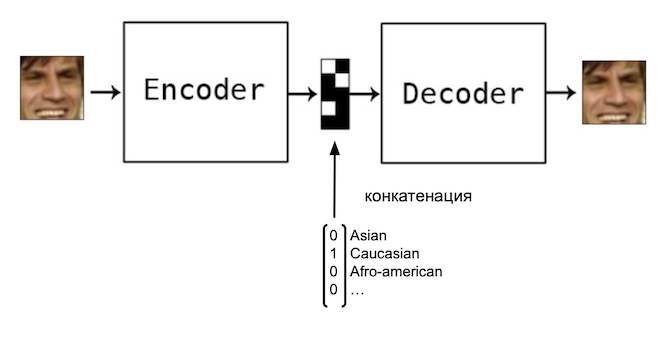

Также можно подавать conditional вектор на вход не только первому слою декодера, но и всем его слоям. Можно также подавать conditional вектор на вход и слоям энкодера.

**Вопрос: на какую задачу обучается ванильный автоэнкодер?**

## GAN

### Устройство GAN

GAN — Generative adversarial Network — генеративно-состязательная сеть. Эта архитектура была придумана в 2014 году специально для задачи генерации новых изображений
(конечно, ГАНы можно при этом использовать для генерации не только картинок, но и других объектов).

Давайте подумаем: **как можно научить нейросеть генерировать новые объекты?**

Самая простая идея: сделать нейросеть, которая на вход будет получать случайный вектор чисел определенного размера, а на выходе выдавать сгенерированную картинку:

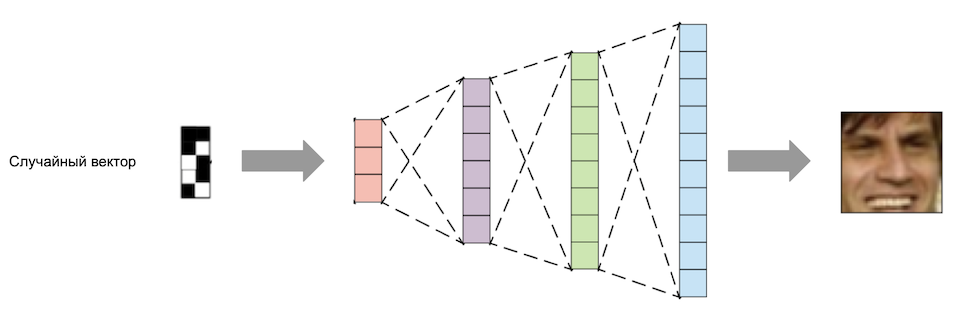

Проблема в этой идее в том, как такую сеть обучать. Если при обучении подавать на вход случайные векторы и выход сети сравнивать с картинками из обучающего датасета, такая сеть научится генерировать только картинки из обучающего датасета. Это довольно бесполезно =)

Хотелось бы, имея ограниченный обучающий датасет, научить нейросеть генерировать разные лица людей. Даже такие, которых нейросеть не видела в процессе обучения (т.е. которых нет в обучающих данных).

Как это сделать? Одна из идей — GAN — генеративно-состязательная сеть.
Вот как она устроена:

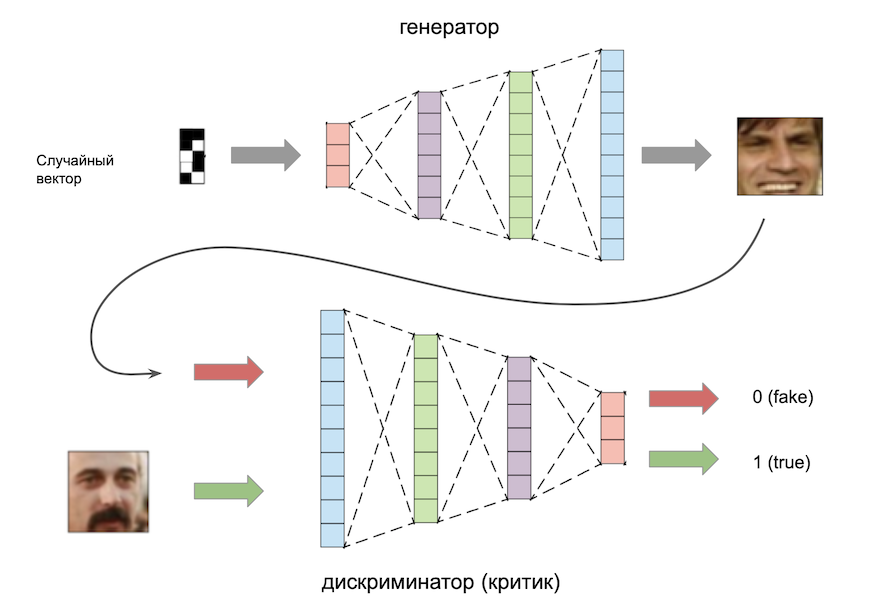

Модель состоит из двух отдельных нейросетей: генератора и дискриминатора. Генератор принимает на вход случайный вектор и выдает на выходе картинку. Дискриминатор принимает на вход картинку и выдает ответ: реальная ли эта картинка или фейковая (сгенерированная генератором).

Генератор и дискриминатор обучаются совместно. Дискриминатор помогает генератору научиться генерировать разнообразные картинки, а не только те, что есть в обучающем датасете.

[Слайды](https://docs.google.com/presentation/d/18XvsfyP4Jpt9HYMSUhISctrcXMGiTkYw/edit?usp=sharing&ouid=113011837198348805491&rtpof=true&sd=true) о том, как происходит обучение такой модели.

Смысл в этом всем такой: дискриминатор быстро учится отличать картинки, сгенерированные генератором, от настоящих (из обучающего датасета). После этого на стадии обучения генератора генератор учится подстраиваться так, чтобы генерировать картинки, которые дискриминатор отличить от настоящих уже не сможет. После этого дискриминатор учится отличать новые картинки, сгенерированные генератором, от настоящих. После этого снова генератор учится генерировать картинки лучше. И так далее.

Это такаое противостояние между генератором и дискриминатором.

**У ГАНов есть некоторые недостатки**:

- ГАН довольно сложно обучить. Нужно подобрать правильные архитектуры генератора и дискриминатора: чтобы дискриминатор был не слишком "умнее" генератора (не обучался хорошо классифицировать картинки сильно быстрее, чем генератор научится хорошо их генерировать). И наоборот: дискриминатор не должен быть сильно "тупее" генератора, иначе генератор не будет получать хороший сигнал для обучения.
- В генераторе ГАНа нужно очень осторожно использовать batchnorm. BatchNorm выравнивает распределения всех элементов батча, из-за этого все сгенерированные в одном батче картинки могут иметь похожие характеристики.
Пример генерации с использованием BatvhNorm:


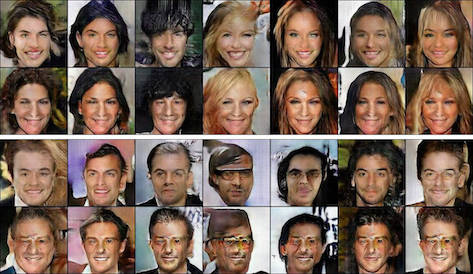

- у ГАНов часто возникает mode collapse: ситуация, когда генератор начинает генерировать примерно одинаковые картинки на любые входные случайные векторы. Есть много техник, как уменьшить такой эффект и сделать генерацию генератора более разнообразной. Пример mode collapse:

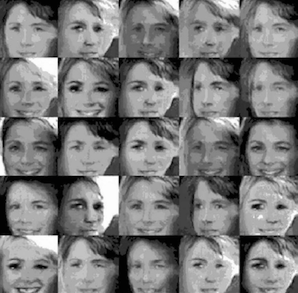

### Практика

Давайте научим ГАН генерировать лица людей. Мы будем использовать тот датасет LFW

Импортируем нужные библиотеки:

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

В разделе ниже — Скачивание и подготовка данных. Весь код аналогичен тому, что был выше в практике по AE. Ячейки этого раздела нужно раскомментировать и запустить, только если вы еще не скачивали данные в этом ноутбуке ранее.

#### Скачивание и подготовка данных

In [ ]:
! wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz
os.system("tar xvzf tmp.tgz && rm tmp.tgz")

--2024-04-24 14:42:43--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

tmp.tgz             100%[===================>] 103.72M  1.80MB/s    in 60s     

2024-04-24 14:43:44 (1.72 MB/s) - ‘tmp.tgz’ saved [108761145/108761145]



0

In [ ]:
images = []

for dirpath, _, filenames in os.walk('lfw-deepfunneled'):
    for fname in filenames:
        if fname.endswith(".jpg"):
            fpath = os.path.join(dirpath,fname)
            image = Image.open(fpath)
            images.append(image)

In [ ]:
len(images)

13233

In [ ]:
def plot_gallery(images, n_row=3, n_col=6, from_torch=False):
    """Helper function to plot a gallery of portraits"""

    if from_torch:
        images = [x.data.numpy().transpose(1, 2, 0) for x in images]

    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])

        plt.xticks(())
        plt.yticks(())

    plt.show()

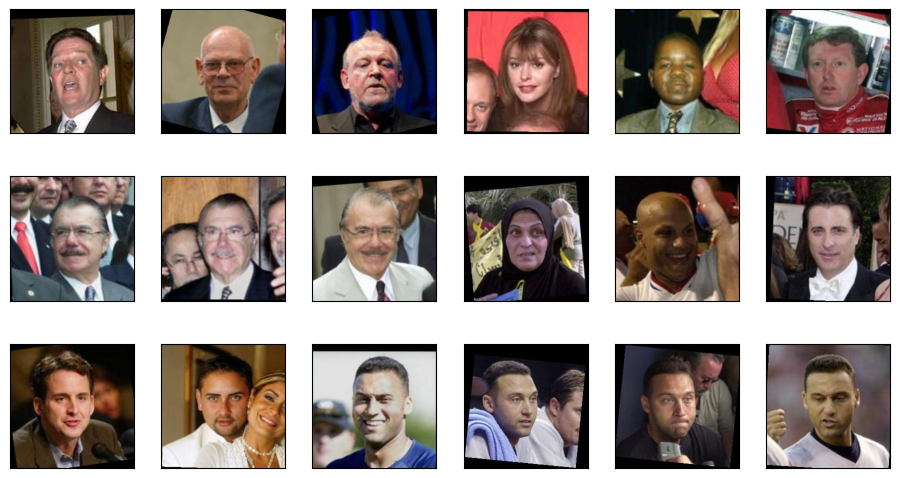

In [ ]:
plot_gallery(images)

In [ ]:
class Faces(Dataset):
    def __init__(self, faces):
        self.data = faces
        self.transform = transforms.Compose([
                                    transforms.CenterCrop((90, 90)),
                                    transforms.Resize((64, 64)),
                                    transforms.ToTensor(),
                                    # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                    ])

    def __getitem__(self, index):

        x = self.data[index]
        return self.transform(x).float()

    def __len__(self):
        return len(self.data)

torch.Size([3, 64, 64])


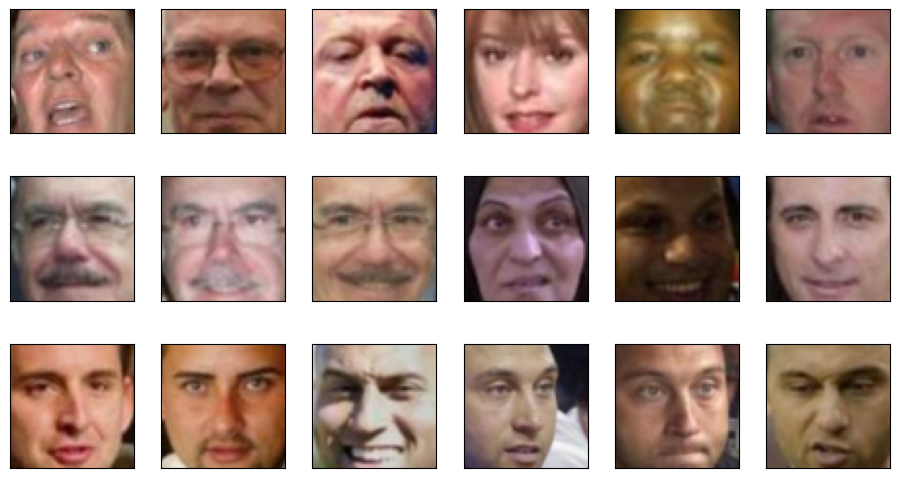

In [ ]:
dataset = Faces(images)

# dataset[0] — это вызов метода __getitem__(0)
img = dataset[0]

print(img.shape)

# отрисовываем картинку и ее маску сегментации
plot_gallery(dataset, from_torch=True)

In [ ]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

g_cpu = torch.Generator().manual_seed(8888)
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size], generator=g_cpu)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)

#### Модель GAN

Отдельно объявим модели дискриминатора и генератора.

Модель дискриминатора — обычная сверточная сеть для бинарной классификации картинок:

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # in: 3 x 64 x 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # out: 64 x 32 x 32

        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        # out: 128 x 16 x 16

        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        # out: 256 x 8 x 8

        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        # out: 512 x 4 x 4

        self.conv5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)
        # out: 1 x 1 x 1

        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        x = self.conv5(x)
        x = self.flatten(x)
        x = self.sigmoid(x)

        return x

Модель генератора — тоже сверточная нейросеть, выход которой должен быть той же размерности, что и картинки в датасете:

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        # in: latent_size x 1 x 1

        self.convT1 = nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(512)
        # out: 512 x 4 x 4

        self.convT2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(256)
        # out: 256 x 8 x 8

        self.convT3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        # out: 128 x 16 x 16

        self.convT4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        # out: 64 x 32 x 32

        self.convT5 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()
        # out: 3 x 64 x 64

    def forward(self, x):

        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))

        x = self.convT5(x)
        x = self.tanh(x)

        return x

Зададим размер случайных векторов, подаваемых генератору для генерации картинок, как 128:

In [ ]:
latent_size = 128

Заведем фиксированный вектор шума, чтобы в процесее обучения сети отслеживать то, как меняется вывод генератора на этом фиксированном векторе:

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


In [ ]:
from IPython.display import clear_output
from torchvision.utils import make_grid

# функция для де-нормализации картинок
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

# функция для отрисовки результатов генерации генератором картинок
# на нашем фиксированном векторе шума
def show_samples(latent_tensors):
    fake_images = generator(latent_tensors)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(fake_images[:64].cpu().detach()), nrow=8).permute(1, 2, 0))
    plt.show()

# функция непосредственного обучения ГАНа
def train(models, opts, loss_fns, epochs, train_loader, val_loader, batch_size=64):

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):
        # печатаем номер текущей эпохи
        print('* Epoch %d/%d' % (epoch+1, epochs))

        # Обучаем сеть на картинках из train_loader
        models["discriminator"].train()
        models["generator"].train()

        # массивы для сохранения значений лоссов и метрик accuracy
        # дискриминатора в процессе обучения сети
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        for i, X_batch in enumerate(train_loader):
            X_batch = X_batch.to(device)

            # 1. Шаг обучения дискриминатора.

            # Очистим градиенты дискриминатора
            opts["discriminator"].zero_grad()

            # 1.1 Получаем лосс на реальных картинках

            # Подаем реальные картинки из батча X_batch на вход дискриминатору
            real_preds = models["discriminator"](X_batch)
            # Правильный ответ дискриминатора на эти картинки должен быть
            # вектором из единиц
            real_targets = torch.ones(X_batch.size(0), 1, device=device)
            # считаем значение лосса дискриминатора на батче реальных картинок
            real_loss = loss_fns["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # 1.2 Получаем лосс на фейковых картинках

            # Сгенерируем фейковые картинки. Для этого сгенерируем случайный вектор шума
            # размера (batch_size, latent_size, 1, 1) и подадим на вход генератору.
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            # Получаем выход генератора на батч случайных векторов
            fake_images = models["generator"](latent)

            # Подаем фейковые картинки из батча X_batch на вход дискриминатору
            fake_preds = models["discriminator"](fake_images)
            # Правильный ответ дискриминатора на эти картинки должен быть
            # вектором из нулей
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            # считаем значение лосса дискриминатора на батче фейковых картинок
            fake_loss = loss_fns["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # 1.3 Обновляем веса дискриминатора: делаем шаг градиентного спуска
            loss_d = real_loss + fake_loss
            loss_d.backward()
            opts["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            # 2. Шаг обучения генератора
            # Очистим градиенты генератора
            opts["generator"].zero_grad()

            # Сгенерируем фейковые картинки. Для этого сгенерируем случайный вектор шума
            # размера (batch_size, latent_size, 1, 1) и подадим на вход генератору.
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            # Получаем выход генератора на батч случайных векторов
            fake_images = models["generator"](latent)

            # Подаем фейковые картинки из батча X_batch на вход дискриминатору
            preds = models["discriminator"](fake_images)
            # Задаем вектор "правильных" ответов на эти картинки как вектор из единиц
            targets = torch.ones(batch_size, 1, device=device)
            # считаем лосс между preds и targets
            loss_g = loss_fns["generator"](preds, targets)

            # Обновляем веса генератора
            loss_g.backward()
            opts["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

            # каждые 100 итераций обучения будем выводить текущие значения метрик
            # и отрисовывать результаты генерации генератором картинок
            # из фиксированных случайных векторов
            if i%100 == 0:
                # Record losses & scores
                losses_g.append(np.mean(loss_g_per_epoch))
                losses_d.append(np.mean(loss_d_per_epoch))
                real_scores.append(np.mean(real_score_per_epoch))
                fake_scores.append(np.mean(fake_score_per_epoch))

                # Log losses & scores (last batch)
                print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                    epoch+1, epochs,
                    losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

                # Show generated images
                clear_output(wait=True)
                show_samples(fixed_latent)

    return losses_g, losses_d, real_scores, fake_scores

Ну и, наконец, объявим модели, оптимизаторы, лоссы, и обучим модель:

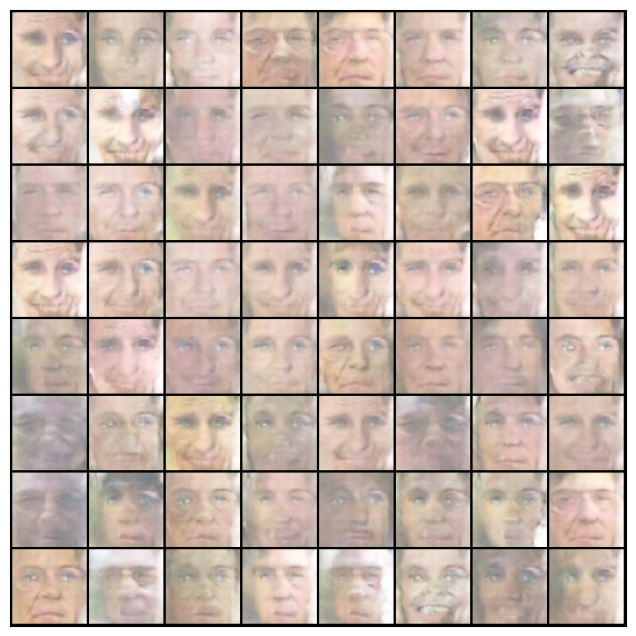

In [ ]:
generator = Generator(latent_size).to(device)
discriminator = Discriminator().to(device)

models = {
    'generator': generator,
    'discriminator': discriminator
}

criterions = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

lr = 0.0002
optimizers = {
        "discriminator": torch.optim.Adam(models["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(models["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

losses_g, losses_d, real_scores, fake_scores = train(models, optimizers, criterions, 40, train_loader, val_loader)

Визуализируем график изменения лоссов и метрик accuracy генератора в течение обучения сети:

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Дополнительно

### Полезные ссылки

- Набор занятий по **Автоэнкодерам** в Deep Learning School:
    - [Лекция: Генеративные модели и автоэнкодеры](https://youtu.be/6qVfC7P9dEc);
    - [Семинар: автоэнкодеры](https://youtu.be/FUXsks9SPOQ);
    - [Семинар: VAE](https://youtu.be/mqPw5Lm810o);


- Набор лекций по **GAN** в Deep Learning School:
    - [Лекция: Генеративные модели. GAN](https://youtu.be/An20DOEOctc);
    - [Семинар: GAN](https://youtu.be/Anocy4ey0vs)


- [Заполненный ноутбук по разным видам атоэнкодеров (Vanilla AE, VAE, Conditional VAE)](https://colab.research.google.com/drive/1FFOQxRgoamg8sS8U5CnbNcKUfw56VSMU?usp=sharing) с пояснениями
- [Статья про VAE на английском с развернутыми объяснениями идеи работы и математическими формулами](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
